In [131]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [132]:
classes = 94
skdim = 10
noise = 0.5
dim_multiplier = 10
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [133]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

def uniform_initializer2(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-0.5, b=0.5)

In [134]:
#secret keys
#ascii 0-94
secret_key = uniform_initializer(skdim, classes)
print(secret_key.shape)

torch.Size([10, 94])


In [135]:
# noise 
def apply_gaussian_noise(tensor, sd, device = torch.device("cuda:0")):
    tensor = tensor + (sd)*torch.randn(*tuple(tensor.shape)).to(device)
    return tensor

class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.device = torch.device("cuda:0") if cuda else torch.device("cpu")
        self.epsilon = epsilon
        
    def apply(self, X):
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wnoise(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        return (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X) > self.epsilon).float()
    
    def apply_wnoise_realistic(self, X, sd):
        #print(X.shape, self.W.shape)
        if sd == 0:
            return self.apply(X)
        encoded = torch.zeros((self.out_dim, X.shape[1])).to(self.device)
        for i in range(X.shape[1]):
            encoded[:,i] = (torch.matmul(apply_gaussian_noise(self.W, sd, device = self.device), X[:,i].view(-1,1)) > self.epsilon).float().view(-1)
        return encoded
    


In [136]:
#One hot net    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon):
        super(One_hot_net, self).__init__()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        self.tail = nn.Linear(feature_len, n_class)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, X):
        X = self.f_encoder.apply_wnoise(X, noise)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        #print(X.shape)
        X = self.output(X)
        #print(X.shape)
        return X
    
    def decrypt(self, X):
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        #print(X.shape)
        X = self.output(X)
        #print(X.shape)
        return X

In [137]:
parameters = {
    'in_dim': skdim,
    'n_class': classes,
    'f_encoder': simple_encoder_wthreshold(skdim*dim_multiplier, skdim, 0),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': dim_multiplier,
    'epsilon': 0,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}

In [138]:
device = torch.device("cuda:0")
model1 = One_hot_net(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon']).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.5, momentum=0.5)


In [139]:
#create training and testing set
def make_data(size, classes = classes):
    data = torch.rand(size) * classes
    return data.long()#, F.one_hot(data.long(), num_classes=classes)

n_epochs = 10
n_batch = 2000
batch_size_train = 50
batch_size_test = 50

train_loader = []
test_loader = []
for i in range(n_batch):
    #train
    indices = make_data(batch_size_train)
    train_loader.append((secret_key[:, indices], indices))
    
    #test
    indices = make_data(batch_size_train)
    test_loader.append((secret_key[:, indices], indices))

#train_loader = [secret_key[:, make_data(batch_size_train)] for i in range(n_batch)]
#test_loader = [secret_key[:, make_data(batch_size_test)] for i in range(n_batch)]

print(train_loader[0][0].shape, train_loader[0][1].shape, train_loader[0][1])

torch.Size([10, 50]) torch.Size([50]) tensor([60,  9, 79, 58, 52, 49, 39, 64, 79, 37, 67, 74, 66, 47, 63, 51, 76, 33,
        53, 54,  2, 58, 14, 70, 37, 59, 10, 68, 77, 63, 60, 19, 89, 60,  2, 46,
        48, 63, 55, 83, 42, 39, 44, 75,  5, 83, 29, 72, 15, 30])


In [140]:
train_losses = []
test_losses = []

In [141]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    train_loss = 0
    for batch_idx, data_set in enumerate(train_loader):
        data = data_set[0].to(device)
        labels = data_set[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape, output)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(float(train_loss))
    print('Epoch: {}, Train set: Avg. loss: {:.6f}'.format(epoch,
        train_loss))
    return model, optimizer
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data_set in test_loader:
            data = data_set[0].to(device)
            labels = data_set[1].to(device)
            output = model(data)
            test_loss += F.nll_loss(output, labels).item()
    test_loss /= len(test_loader)
    test_losses.append(float(test_loss))
    #print(output[:,0]-data[:,0])
    print('Test set: Avg. loss: {:.6f}'.format(
        test_loss))
    return test_loss

In [142]:
model_name = "crypto_net1"
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)

Epoch: 1, Train set: Avg. loss: 0.120309
Test set: Avg. loss: 0.018157
Epoch: 2, Train set: Avg. loss: 0.013416
Test set: Avg. loss: 0.010416
Epoch: 3, Train set: Avg. loss: 0.008817
Test set: Avg. loss: 0.007514
Epoch: 4, Train set: Avg. loss: 0.007060
Test set: Avg. loss: 0.006306
Epoch: 5, Train set: Avg. loss: 0.005877
Test set: Avg. loss: 0.005439
Epoch: 6, Train set: Avg. loss: 0.005042
Test set: Avg. loss: 0.004830
Epoch: 7, Train set: Avg. loss: 0.004355
Test set: Avg. loss: 0.004209
Epoch: 8, Train set: Avg. loss: 0.004204
Test set: Avg. loss: 0.003919
Epoch: 9, Train set: Avg. loss: 0.003829
Test set: Avg. loss: 0.003341
Epoch: 10, Train set: Avg. loss: 0.003396
Test set: Avg. loss: 0.003326


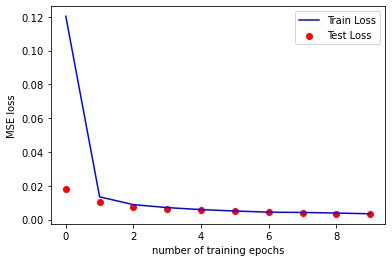

In [143]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.scatter(range(len(test_losses)), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training epochs')
plt.ylabel('MSE loss')
plt.show()

In [151]:
#Testing Encoded sentence
#message = "It is time to test the model on real-world data"#. We must choose a sentence and an image. We choose the following sentence from Wikipedia: Anthony Edward \"Tony\" Stark is a character portrayed by Robert Downey Jr. in the MCU film franchise and for the image, we use the same Tony Stark’s image from the beginning of the article. The following code is used to embedding and extracting the message:"
message = "abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [152]:
def encrypt(message, model, secret_key, n = noise):
    message_index = [(ord(c)-32) for c in message]
    #print(message_index)
    #print(secret_key)
    #sk = secret_key.cpu()
    #print(sk.shape, sk.device)
    secret_message = secret_key[:, message_index]#.to(device)
    #print(secret_message[:,0])
    return model.f_encoder.apply_wnoise_realistic(secret_message, n)

In [157]:
encrypted_message = encrypt(message, model1, secret_key, n = noise)

In [158]:
print(encrypted_message, encrypted_message.shape, torch.sum(encrypted_message[:,-1]-encrypted_message[:,-2]))
#plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)


tensor([[1., 1., 1.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.]], device='cuda:0') torch.Size([100, 53]) tensor(6., device='cuda:0')


In [159]:
def determine_letter(one_hots):
    ind = torch.argmax(one_hots, dim=1)
    m = ""
    for i in ind:
        m += chr(int(i)+32)
    return m

def decrypt(encrypted_message, model, secret_key):
    raw_m = model.decrypt(encrypted_message)
    m = determine_letter(raw_m)
    return m

In [160]:
decrypted_m = decrypt(encrypted_message, model1, secret_key)
print(decrypted_m)
def decryption_accuracy(message, decrypted_message):
    count = 0
    for i in range(len(message)):
        if message[i] == decrypted_message[i]:
            count+=1
    return count/len(message) * 100
print("decryption accuracy is {}%".format(round(decryption_accuracy(message, decrypted_m), 2)))

abcdefghijklmnopqrestuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
decryption accuracy is 100.0%


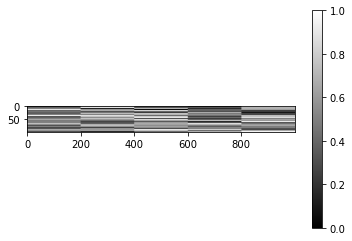

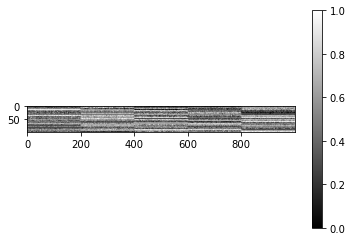

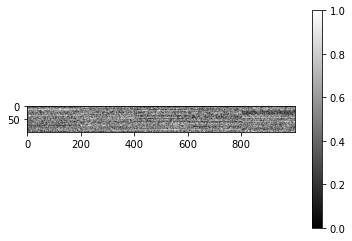

In [161]:
#Visualize variance caused by noise
def visualize(message, model, secret_key, n = noise):
    encrypted_message = encrypt(message, model, secret_key, n = n)
    #print(encrypted_message)
    #print(torch.sum(encrypted_message[:,1]-encrypted_message[:,0]))
    plt.imshow(encrypted_message.cpu().detach().numpy(),  cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 0)
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = noise)
visualize("a"*200+"b"*200+"c"*200+"d"*200+"e"*200, model1, secret_key, n = 2.5)

In [130]:
#message_index = [(ord(c)-32) for c in message]
#print(message_index)
#secret_message = secret_key[:, message_index]#.to(device)
#output = model1(secret_message)
#print(output[:,0]-secret_message[:,0])